In [5]:
import pandas as pd
import numpy as np
import os
import math
from scipy.io import wavfile
import matplotlib.pyplot as plt
import python_speech_features as psf
import h5py

In [10]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
temp.pop(-1)
temp.pop(-1)  # remove this one
path = '/'.join(temp)
filename = '/data_v_7_stc/meta/meta.txt'

### Read meta file

In [11]:
meta = pd.read_csv(path + filename, sep="\t", header=None)
meta.columns = ["filename", "where", "something", "length", "label"]
print(meta.shape)
meta.head(2)

(11307, 5)


,filename,where,something,length,label
0,background_0001.wav,office,0,9.45850,background
1,background_0001_time_stretch_0.wav,office,0,9.98907,background


In [12]:
print(meta["label"].unique(), meta["label"].nunique())
meta.shape[0]

['background' 'bags' 'door' 'keyboard' 'knocking_door' 'ring' 'speech'
 'tool'] 8


11307

### Read one file

In [13]:
fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + meta["filename"].loc[13])

print(len(data) / meta.length.loc[11])
# meta["filename"].loc[2]
print(fs)

14526.846124567788
22050


<function matplotlib.pyplot.show(*args, **kw)>

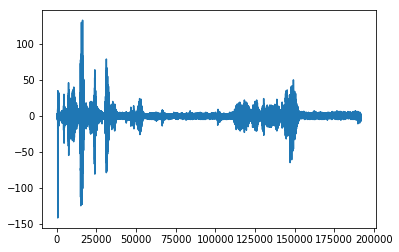

In [14]:
plt.plot(data)
plt.show

### Create feature vectors

In [15]:
# two types of features - mfcc or logfbank
# example for one file
mfcc = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=40, numcep=20)
logfbank = psf.logfbank(data, samplerate=fs, nfft=1024, nfilt=40)

print('MFCC shape:', mfcc.shape)
print('Logfbank shape:', logfbank.shape)

MFCC shape: (868, 20)
Logfbank shape: (868, 40)


<function matplotlib.pyplot.show(*args, **kw)>

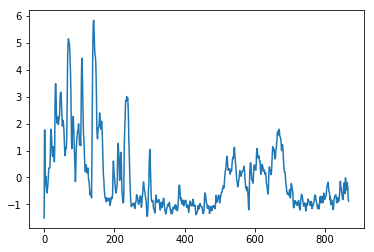

In [16]:
plt.plot(mfcc[:, 0])
plt.show

In [17]:
# add a column with a feature vectors
def make_fv(record):
    # load file
    fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + record)
    # approximately numcep is fs/2000 ~ (8 for 16 kHz and 11 for 22 kHz)
    mfcc = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=26, numcep=13)
#     fbank = psf.logfbank(data, samplerate=fs, nfft=1024, nfilt=13)
    return mfcc
    
meta['features'] = meta.filename.apply(lambda x: make_fv(x))
meta.head(2)

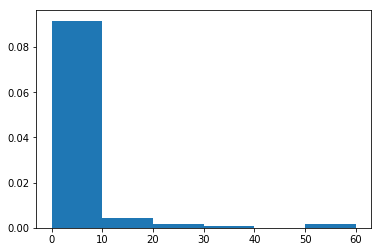

In [22]:
plt.hist(meta.length, bins=6, density=True, range=(0, 60))
plt.show()

### Cut large audiofiles

In [23]:
maxlen = 6  # in seconds

def cut_large(record):
    global maxlen
    if record.length < maxlen:
        res = pd.DataFrame([(record.filename, record.features, record.label)], columns=['filename', 'features', 'label'])
        return res
    
    n_rows = math.ceil(record.length / maxlen)
    df = pd.DataFrame(columns=['filename', 'features', 'label'])
    
    list_of_arrays = np.array_split(record.features, n_rows, axis=0)
    for array in list_of_arrays:
        df = df.append({'filename': record.filename, 'features': array, 'label': record.label}, ignore_index=True)
    
    return df

list_of_frames = meta.apply(lambda x: cut_large(x), axis=1)
cutted = pd.concat(list(list_of_frames))
cutted = cutted.reset_index(drop=True)
cutted.head(2)

,filename,features,label
0,background_0001.wav,"[[4.633583646783074, -20.841588444422122, -4.9...",background
1,background_0001.wav,"[[6.101738010630771, -21.94071074611402, 3.154...",background


### Prepare training data

In [24]:
X_train, Y_train = cutted.features, cutted.label

# add zeros at the end
def equalize(array, maxlen, n_features):
    length = array.shape[0]
    if length < maxlen:
        additional = np.array([[0 for i in range(n_features)] for j in range(maxlen - length)])
        res = np.concatenate([array, additional])
        return res
    return array

# pad sequence
def pad_row(series):
    length = max(series.apply(lambda x: len(x)))
    n_features = series[0].shape[1]
    result = series.apply(lambda x: equalize(x, length, n_features))
    return result

tmp = pad_row(X_train)
X_train = np.stack(tmp.values)
print('Vectors are padded')

# make a dummy target
Y_train = pd.get_dummies(Y_train)

print(len(X_train), 'train sequences')

Vectors are padded
16241 train sequences


### Save the train data to file

In [ ]:
h5f = h5py.File('train.h5', 'w')
h5f.create_dataset('train', data=X_train)
h5f.close()

h5f = h5py.File('target.h5', 'w')
h5f.create_dataset('target', data=Y_train)
h5f.close()